In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import os
os.chdir("/content/drive/MyDrive/sentiment_analysis")

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
# specify GPU
device = torch.device("cuda")

In [ ]:
df = pd.read_csv(r"dataset/train.csv", encoding="latin1")
df_test = pd.read_csv(r"dataset/test.csv", encoding = "latin1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
df_test.dropna(subset=['sentiment'], inplace=True)

In [ ]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical form
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])
df_test["sentiment"] = label_encoder.transform(df_test["sentiment"])
df = df[["text","sentiment"]]
df_test = df_test[["text","sentiment"]]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [ ]:
df.isna().sum()

text         1
sentiment    0
dtype: int64

In [ ]:
df.dropna(inplace= True)
df.shape

(27480, 2)

In [ ]:
def len_sent(sent):
    return len(sent.split(" "))

df["sent_lengths"] = df["text"].apply(len_sent)
df_test["sent_lengths"] = df_test["text"].apply(len_sent)

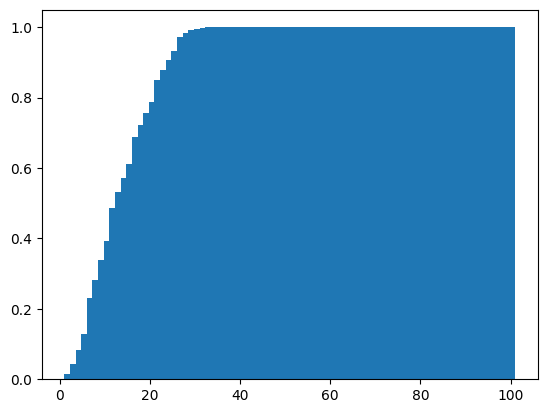

In [ ]:
plt.hist(df["sent_lengths"], bins = 80, cumulative=True, density=True)
plt.show()

In [ ]:
sent_len_999  = int(df["sent_lengths"].quantile(0.999))
print("the 99.9 percentile of sentence lengths is",sent_len_999)

the 99.9 percentile of sentence lengths is 32


In [ ]:
# removing the sentences whose length is more than 32. so we will lose around 27 data points
df = df[df["sent_lengths"]<=sent_len_999]
df_test = df_test[df_test["sent_lengths"]<=sent_len_999]
df.shape

(27455, 3)

In [ ]:
df["sentiment"].value_counts()

sentiment
1    11107
2     8577
0     7771
Name: count, dtype: int64

In [ ]:
# converting the strings into lower case.
df["text"] = df["text"].apply(str.lower)
df_test["text"] = df_test["text"].apply(str.lower)
df.head()

,text,sentiment,sent_lengths
0,"i`d have responded, if i were going",1,8
1,sooo sad i will miss you here in san diego!!!,0,11
2,my boss is bullying me...,0,5
3,what interview! leave me alone,0,6
4,"sons of ****, why couldn`t they put them on t...",0,15


In [ ]:
# import BERT-base pretrained model
bert = BertModel.from_pretrained("bert-base-uncased")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# dropping the sentence length column from dataframe
df.drop(["sent_lengths"], axis = 1, inplace = True)
df_test.drop(["sent_lengths"], axis = 1, inplace = True)
df.head()

,text,sentiment
0,"i`d have responded, if i were going",1
1,sooo sad i will miss you here in san diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"sons of ****, why couldn`t they put them on t...",0


In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])
test_text, test_labels = df_test["text"], df_test["sentiment"]

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = sent_len_999,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = sent_len_999,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = sent_len_999,
    padding="max_length",
    truncation=True,
    return_token_type_ids=False
)

In [88]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2
      self.fc2 = nn.Linear(512,256)

      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(256,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      # Pass the inputs to the model
      output = self.bert(sent_id, attention_mask=mask)

      # Extract the last hidden states and the pooler_output from the model's output
      last_hidden_state, pooler_output = output.last_hidden_state, output.pooler_output

      x = self.fc1(pooler_output)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)

      # Output layer
      x = self.fc3(x)

      # Apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = F.cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = F.cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 20
early_stopping_patience = 3  # Number of epochs to wait before stopping if validation loss doesn't improve
no_improvement_counter = 0  # Counter to track epochs with no improvement

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        no_improvement_counter = 0  # Reset the counter if there's an improvement
    else:
        no_improvement_counter += 1

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Check if validation loss hasn't improved for a certain number of epochs
    if no_improvement_counter >= early_stopping_patience:
        print(f'\nValidation loss has not improved for {early_stopping_patience} epochs. Early stopping...')
        break  # Stop training


 Epoch 1 / 20
  Batch    50  of    601.
  Batch   100  of    601.
  Batch   150  of    601.
  Batch   200  of    601.
  Batch   250  of    601.
  Batch   300  of    601.
  Batch   350  of    601.
  Batch   400  of    601.
  Batch   450  of    601.
  Batch   500  of    601.
  Batch   550  of    601.
  Batch   600  of    601.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training Loss: 1.039
Validation Loss: 0.930

 Epoch 2 / 20
  Batch    50  of    601.
  Batch   100  of    601.
  Batch   150  of    601.
  Batch   200  of    601.
  Batch   250  of    601.
  Batch   300  of    601.
  Batch   350  of    601.
  Batch   400  of    601.
  Batch   450  of    601.
  Batch   500  of    601.
  Batch   550  of    601.
  Batch   600  of    601.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training L

In [86]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [87]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [89]:
preds = np.argmax(preds, axis = 1)
test_y = label_encoder.inverse_transform(test_y)
preds = label_encoder.inverse_transform(preds)

In [90]:
# model's performance
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

    negative       0.64      0.50      0.57      1001
     neutral       0.54      0.71      0.61      1429
    positive       0.70      0.55      0.61      1101

    accuracy                           0.60      3531
   macro avg       0.63      0.59      0.60      3531
weighted avg       0.62      0.60      0.60      3531

